<a href="https://colab.research.google.com/github/sagnik-sudo/Learning-CNN/blob/main/ResNet_Day_Night_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Day/Night Classifier

Automatically sorts images into day/night categories and trains a ResNet-18 classifier for real-time prediction.
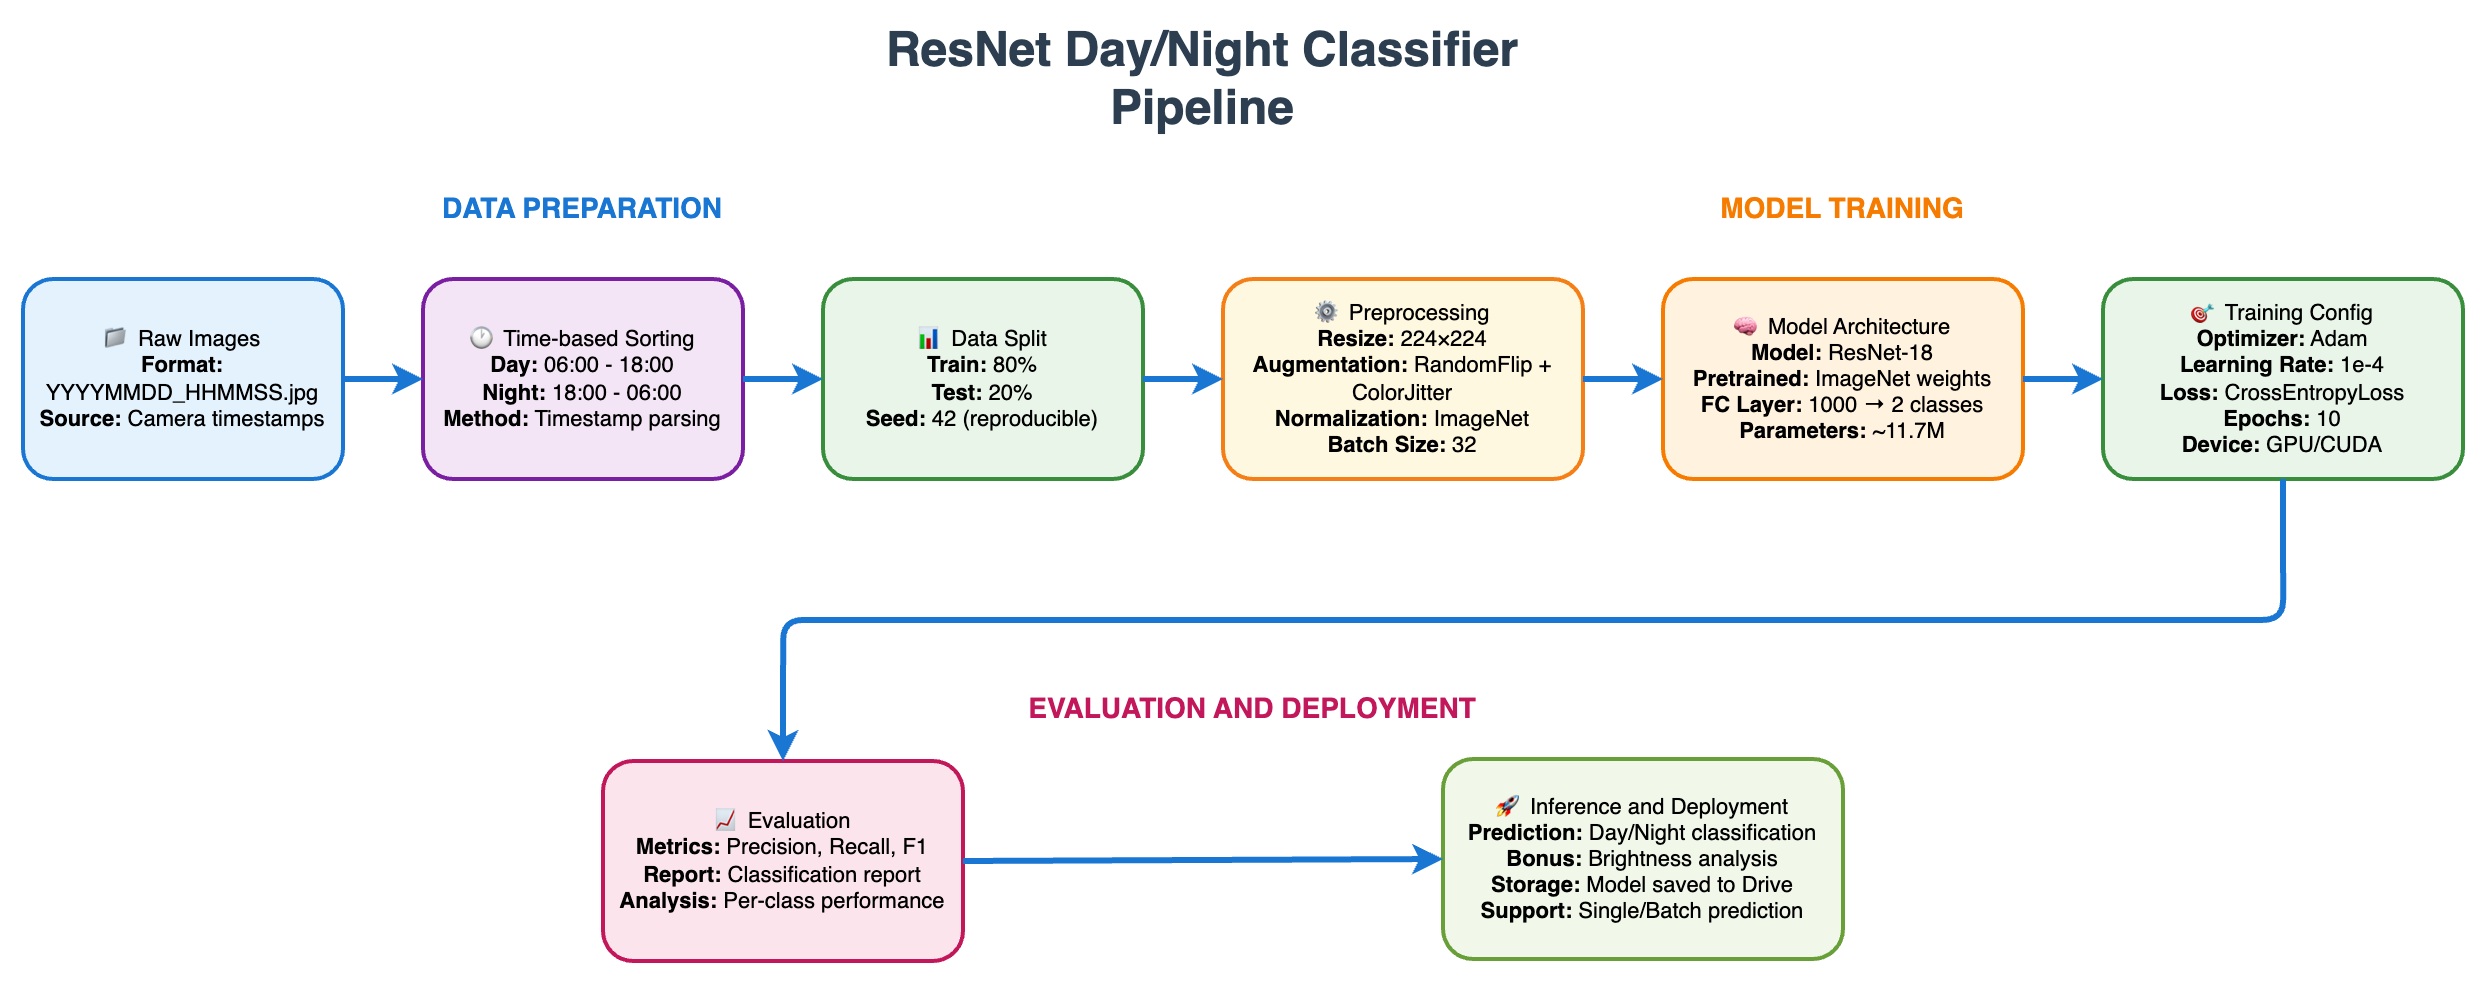

In [1]:
!pip install segmentation-models-pytorch timm --quiet
!pip install --upgrade sympy
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existi

In [2]:
!apt-get update -qq && apt-get install -qq tree

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package tree.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [3]:
!unzip "/content/drive/MyDrive/daynight.zip" -d "/content/drive/MyDrive/DN"

Archive:  /content/drive/MyDrive/daynight.zip
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_072507.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_075502.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_082503.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_085511.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_092511.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_095505.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_105513.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_112505.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_115515.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_122510.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/20151101_125509.jpg  
  inflating: /content/drive/MyDrive/DN/DNIM/Image/00000850/2015

In [4]:
!tree /content/drive/MyDrive/DN -L 5 > tree.txt

### Data Organization
**Time-based sorting** of images into day/night folders:
- Parse timestamps from filename format: `YYYYMMDD_HHMMSS.jpg`
- Day hours: 06:00 - 18:00
- Automatically move images to respective folders (`/day`, `/night`)
- Manual Sorting of Outliers

In [5]:
import os
import shutil
from datetime import datetime

# === CONFIGURE THESE PATHS ===
src_root   = '/content/drive/MyDrive/DN/DNIM/Image'   # where your camera subfolders live
dest_day   = '/content/drive/MyDrive/DN/DNIM/day'     # where to move daytime images
dest_night = '/content/drive/MyDrive/DN/DNIM/night'   # where to move nighttime images

# Create target directories if they don’t exist
os.makedirs(dest_day, exist_ok=True)
os.makedirs(dest_night, exist_ok=True)

# Define what you consider “day” hours
DAY_START = 6   # inclusive: 06:00
DAY_END   = 18  # exclusive: 18:00

# Walk through each camera folder
for camera_id in os.listdir(src_root):
    camera_dir = os.path.join(src_root, camera_id)
    if not os.path.isdir(camera_dir):
        continue

    for fname in os.listdir(camera_dir):
        if not fname.lower().endswith('.jpg'):
            continue

        # Extract and parse timestamp: 'YYYYMMDD_HHMMSS'
        ts_str = os.path.splitext(fname)[0]
        try:
            ts = datetime.strptime(ts_str, '%Y%m%d_%H%M%S')
        except ValueError:
            # skip files that don’t match the pattern
            continue

        # Decide destination
        if DAY_START <= ts.hour < DAY_END:
            target_dir = dest_day
        else:
            target_dir = dest_night

        # Move the file
        src_path  = os.path.join(camera_dir, fname)
        dst_path  = os.path.join(target_dir, fname)
        shutil.move(src_path, dst_path)

print("Done! Images have been moved into ‘day’ and ‘night’ folders.")

Done! Images have been moved into ‘day’ and ‘night’ folders.


### Data Preprocessing
**Training transforms:**
- Resize to 224×224 (ResNet input size)
- Random horizontal flip + color jitter for augmentation
- ImageNet normalization

### Model Architecture
- **Base model:** ResNet-18 with ImageNet pretrained weights
- **Modification:** Replace final FC layer (1000 → 2 classes)
- **Optimizer:** Adam (lr=1e-4)
- **Loss:** CrossEntropyLoss



In [12]:
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from PIL import Image, ImageStat
import io

drive.mount('/content/drive', force_remount=True)

data_root = '/content/drive/MyDrive/DN/DNIM'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=data_root, transform=train_transform)
n_total = len(full_dataset)
n_test  = int(0.2 * n_total)
n_train = n_total - n_test

train_ds, test_ds = random_split(
    full_dataset,
    [n_train, n_test],
    generator=torch.Generator().manual_seed(42)
)
test_ds.dataset.transform = eval_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch():
    model.train()
    running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss = correct = total = 0
    all_preds = []; all_labels = []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    return running_loss/total, correct/total, all_labels, all_preds

num_epochs = 10
for epoch in range(1, num_epochs+1):
    tr_loss, tr_acc = train_one_epoch()
    te_loss, te_acc, _, _ = evaluate(test_loader)
    print(f"Epoch {epoch:02d} | "
          f"Train loss {tr_loss:.4f}, acc {tr_acc:.4f} | "
          f"Test  loss {te_loss:.4f}, acc {te_acc:.4f}")

_, _, y_true, y_pred = evaluate(test_loader)
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

uploaded = files.upload()
fname, data = next(iter(uploaded.items()))
img = Image.open(io.BytesIO(data)).convert('RGB')

model.eval()
inp = eval_transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    pred = model(inp).argmax(dim=1).item()
label = full_dataset.classes[pred]
print(f"{fname} → {label}")

if label == 'day':
    gray = img.convert('L')
    stat = ImageStat.Stat(gray)
    mean_intensity = stat.mean[0]
    brightness_pct = (mean_intensity / 255) * 100
    print(f"Estimated brightness: {brightness_pct:.1f}%")

Mounted at /content/drive
Epoch 01 | Train loss 0.1953, acc 0.9136 | Test  loss 0.1502, acc 0.9619
Epoch 02 | Train loss 0.0810, acc 0.9732 | Test  loss 0.1220, acc 0.9654
Epoch 03 | Train loss 0.0444, acc 0.9845 | Test  loss 0.1481, acc 0.9585
Epoch 04 | Train loss 0.0324, acc 0.9879 | Test  loss 0.1165, acc 0.9792
Epoch 05 | Train loss 0.0233, acc 0.9914 | Test  loss 0.1275, acc 0.9654
Epoch 06 | Train loss 0.0164, acc 0.9948 | Test  loss 0.1207, acc 0.9654
Epoch 07 | Train loss 0.0065, acc 0.9983 | Test  loss 0.1128, acc 0.9689
Epoch 08 | Train loss 0.0063, acc 0.9991 | Test  loss 0.1271, acc 0.9689
Epoch 09 | Train loss 0.0088, acc 0.9983 | Test  loss 0.1303, acc 0.9758
Epoch 10 | Train loss 0.0079, acc 0.9991 | Test  loss 0.1284, acc 0.9758
              precision    recall  f1-score   support

         day       0.99      0.96      0.97       140
       night       0.97      0.99      0.98       149

    accuracy                           0.98       289
   macro avg       0.98   

Saving aachen_nexus4_seq7_0240.png to aachen_nexus4_seq7_0240 (1).png
aachen_nexus4_seq7_0240 (1).png → day
Estimated brightness: 43.2%


In [13]:
import torch

save_path = '/content/drive/MyDrive/DN/DNIM/day_night_resnet18.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/DN/DNIM/day_night_resnet18.pth


### Testing the model

In [17]:
import torch
from torchvision import transforms, models
from PIL import Image, ImageStat
from google.colab import files
import io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/DN/DNIM/day_night_resnet18.pth'))
model.to(device).eval()

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

uploaded = files.upload()  # allows multi-file selection
for fname, data in uploaded.items():
    img = Image.open(io.BytesIO(data)).convert('RGB')
    inp = eval_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(inp).argmax(dim=1).item()
    label = ['day', 'night'][pred]
    print(f"{fname} → {label}")
    if label == 'day':
        gray = img.convert('L')
        stat = ImageStat.Stat(gray)
        brightness_pct = stat.mean[0] / 255 * 100
        print(f"Estimated brightness: {brightness_pct:.1f}%\n")

Saving aachen_nexus4_seq7_0240.png to aachen_nexus4_seq7_0240 (3).png
Saving aachen_nexus4_seq7_0232.png to aachen_nexus4_seq7_0232.png
Saving aachen_nexus4_seq7_0237.png to aachen_nexus4_seq7_0237.png
Saving aachen_nexus4_seq7_0228.png to aachen_nexus4_seq7_0228.png
Saving aachen_nexus4_seq7_0220.png to aachen_nexus4_seq7_0220.png
Saving aachen_nexus4_seq7_0122.png to aachen_nexus4_seq7_0122.png
Saving aachen_nexus4_seq7_0121.png to aachen_nexus4_seq7_0121.png
Saving aachen_nexus4_seq7_0100.png to aachen_nexus4_seq7_0100.png
Saving aachen_nexus4_seq7_0086.png to aachen_nexus4_seq7_0086.png
aachen_nexus4_seq7_0240 (3).png → day
Estimated brightness: 43.2%

aachen_nexus4_seq7_0232.png → day
Estimated brightness: 43.8%

aachen_nexus4_seq7_0237.png → day
Estimated brightness: 37.5%

aachen_nexus4_seq7_0228.png → day
Estimated brightness: 53.0%

aachen_nexus4_seq7_0220.png → day
Estimated brightness: 49.9%

aachen_nexus4_seq7_0122.png → day
Estimated brightness: 42.0%

aachen_nexus4_seq7_0